In [1]:
%matplotlib inline
import os

import cv2
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchmetrics.classification import Dice
from torchvision import transforms
from torchmetrics.classification import BinaryConfusionMatrix
import torchvision.models.segmentation

from utilities import AITEXPatchedSegmentation
from model_architectures import BinaryClassifier, MiniUNet


c:\compute\envs\fdd\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
c:\compute\envs\fdd\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [55]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc


class TverskyLoss(nn.Module):
    def __init__(self):
        super(TverskyLoss, self).__init__()
        self.smooth = 1.0
        self.alpha = 0.7

    def forward(self, y_true, y_pred):
        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()
        
        tp = (y_true_flat * y_pred_flat).sum()
        fn = (y_true_flat * (1 - y_pred_flat)).sum()
        fp = ((1 - y_true_flat) * y_pred_flat).sum()
        
        return 1 - (tp + self.smooth) / (tp + self.alpha * fn + (1 - self.alpha) * fp + self.smooth)
    



In [74]:
# Define paths
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
model_dir = os.path.join(root, "models")
data_dir = os.path.join(root, "data")
aitex_dir = os.path.join(data_dir, "aitex")

# Load dataset with transforms and split
transform = transforms.Compose([])
data = AITEXPatchedSegmentation(aitex_dir, transform=transform)#, normal_only=True)
num_samples = len(data)
train_samples = int(num_samples * 0.95)
val_samples = num_samples - train_samples
train, val = random_split(data, [train_samples, val_samples])

bs = 4
train_loader = DataLoader(train, batch_size=bs)
val_loader = DataLoader(val, batch_size=bs, shuffle=False)


In [128]:
device = "cuda"

model = torchvision.models.segmentation.fcn_resnet101(pretrained=False)
model.classifier[4] = torch.nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
model = model.to(device)

optimizer=torch.optim.Adam(params=model.parameters(),lr=1e-2)
criterion = TverskyLoss()
# criterion = torch.nn.MSELoss()
# criterion = torch.nn.CrossEntropyLoss()

In [130]:
model.train()
for itr in range(50):
    losses = []
    for img, mask in train_loader:
        cur_shape = list(img.shape)
        cur_shape[1] = 3
        x = img.expand(cur_shape).to(device)

        optimizer.zero_grad()
        y_pred = model(x)['out']
        loss=criterion(y_pred, mask.to(device))
        loss.backward()
        losses.append(loss.item())
    print(np.mean(losses))

0.9503989937630567
0.9500984414057299
0.9504814893007278
0.9501773836937818
0.9504581893032248
0.9501030106436122
0.9500307874246077
0.9502446854656393
0.9503997334025123
0.9502131817015734
0.9501926749944687
0.9502864899960431
0.950323145497929
0.950336142019792
0.950020968914032
0.949938877062364
0.9501024349169298
0.9502876726063815
0.9500081498514522
0.9501408772035078
0.9499191018668088
0.9504537352106788
0.9502028497782621
0.9502403885126114
0.9505593885074962
0.9503228637305173
0.9502184336835687
0.9500912007960406
0.9500236741521142
0.950363886627284
0.9499161880124699
0.9505612606352026
0.9500725933096625
0.9504782394929365
0.9502308558334004
0.9501768919554624
0.9499622583389282
0.9502558383074674
0.9503563263199546
0.9500516937537626
0.9499466554685072
0.9501509720628912
0.9501996053890749
0.9503523382273588
0.9504842256957834
0.9500926055691459
0.9505039074204185
0.9502617743882266
0.9502835991707715
0.9503567151047967


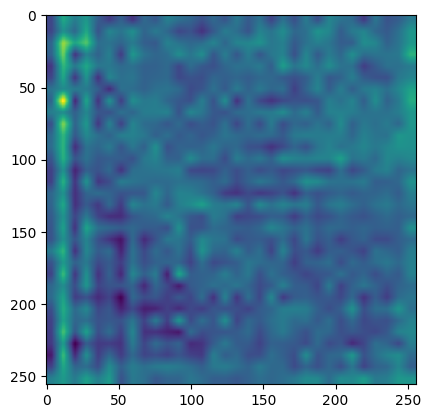

In [125]:
plt.imshow(y_pred[0].reshape(256, 256).cpu().detach())